In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

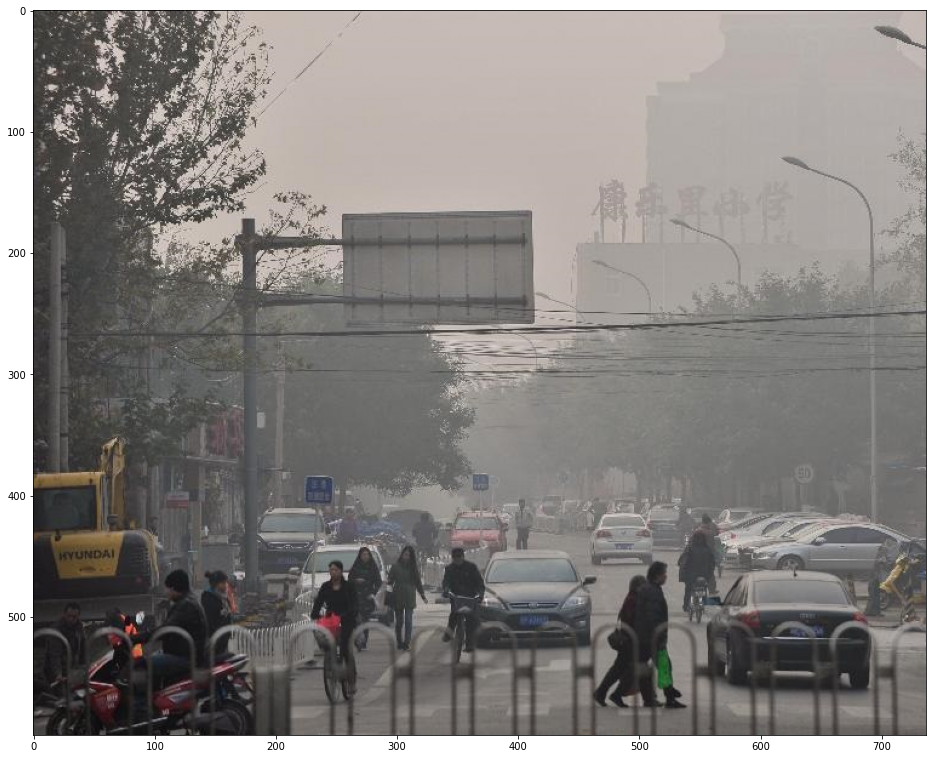

In [2]:
# src = cv2.imread('img/outdoor/hazy/0001_0.8_0.2.jpg')
# img = cv2.imread('img/outdoor/clear/0001.png')
src = cv2.imread('img/realworld/BJ_Bing_185.jpeg')
# src = cv2.imread('img/realworld/XA_Google_266.jpeg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
img = src / 255
plt.figure(figsize=(16, 16))
plt.imshow(img)

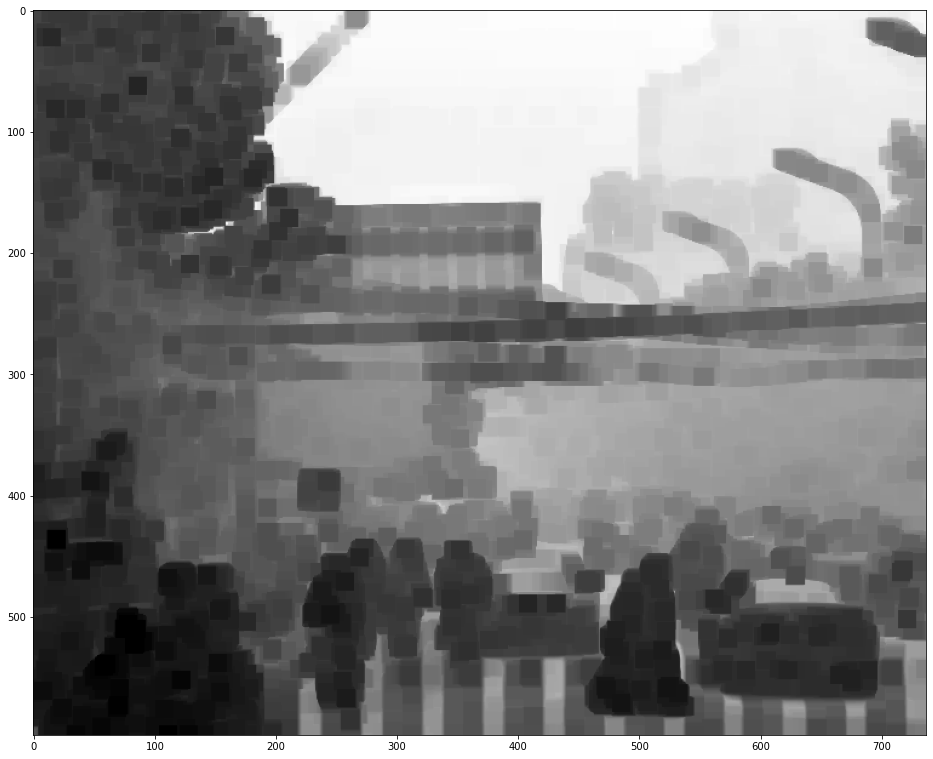

In [3]:
def get_dark_channel(img, patch_size):
    dark_channel = np.min(img, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(patch_size, patch_size))
    dark = cv2.erode(dark_channel,kernel)

    return dark

dark = get_dark_channel(img, 15)
plt.figure(figsize=(16, 16))
plt.imshow(dark, cmap='gray')

In [4]:
def estimate_atm_light(img, dark):
    darkvec = dark.reshape(img.shape[0] * img.shape[1])
    imvec = img.reshape(img.shape[0] * img.shape[1], 3)
    num_top_pixels = int(img.shape[0] * img.shape[1] / 1000)
    sort_indices = darkvec.argsort()[::-1]

    atm_light = imvec[sort_indices[:num_top_pixels]].mean(axis=0)
    # atm_light = imvec[sort_indices[0]] # Use max instead of min

    return atm_light

In [5]:
atm_light = estimate_atm_light(img, dark)
print(atm_light)

[0.78183601 0.73869875 0.72130125]


In [6]:
def estimate_transmission(img, atm_light, omega, patch_size):
    normalized_img = np.empty(img.shape, img.dtype)

    for channel in range(3):
        normalized_img[:, :, channel] = img[:, :, channel] / atm_light[channel]

    transmission = 1 - omega*get_dark_channel(normalized_img, patch_size)
    return transmission

In [7]:
transmission = estimate_transmission(img, atm_light, 0.95, 15)

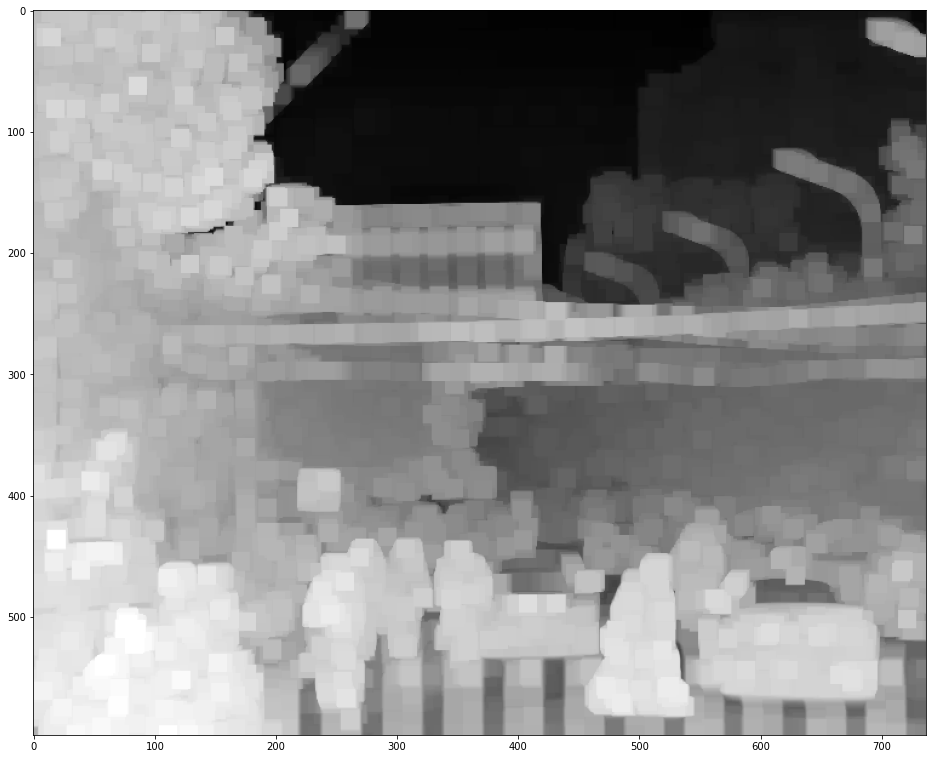

In [8]:
plt.figure(figsize=(16, 16))
plt.imshow(transmission, cmap='gray')

In [9]:
from cv2.ximgproc import guidedFilter

In [10]:
def soft_matting(img, transmission, radius=60):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    transmission = np.float32(transmission)
    gray = np.float32(gray)/255
    eps = 0.0001
    transmission_refined = guidedFilter(img, transmission, radius, eps)
    return transmission_refined

In [11]:
transmission_refined = soft_matting(src, transmission)

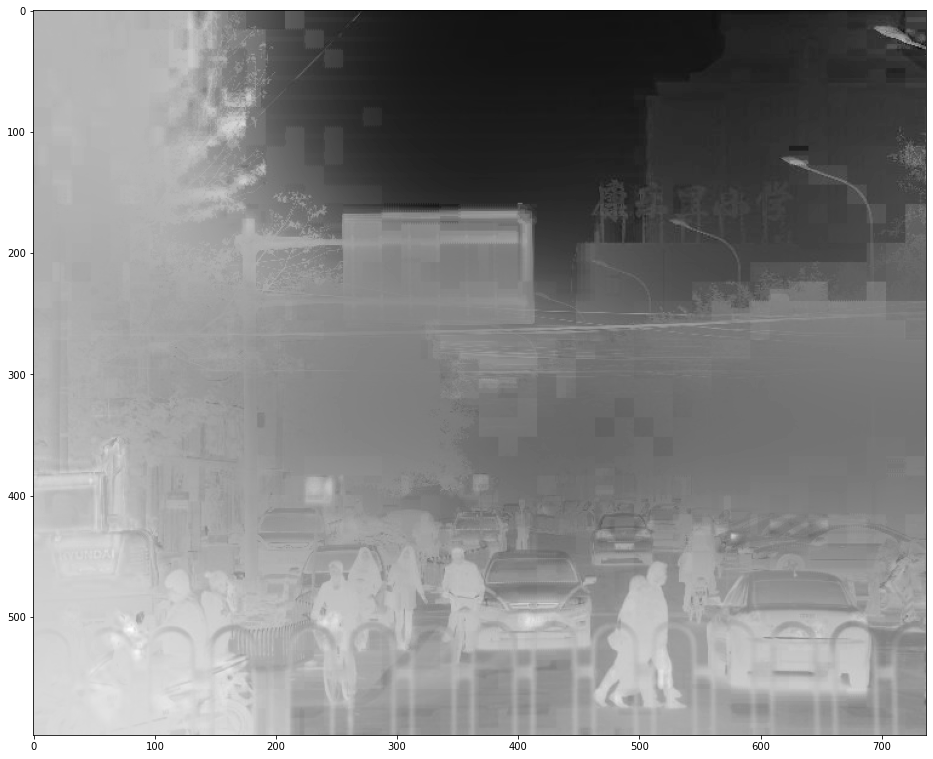

In [12]:
plt.figure(figsize=(16, 16))
plt.imshow(transmission_refined, cmap='gray')

In [13]:
def recover(img, atm_light, transmission, t0=0.1):
    dehazed = np.empty(img.shape, img.dtype)

    for channel in range(3):
        dehazed[:, :, channel] = ((img[:, :, channel] - atm_light[channel]) / cv2.max(transmission, t0)
                                  + atm_light[channel])
    
    return dehazed

In [14]:
dehazed = recover(img, atm_light, transmission_refined)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


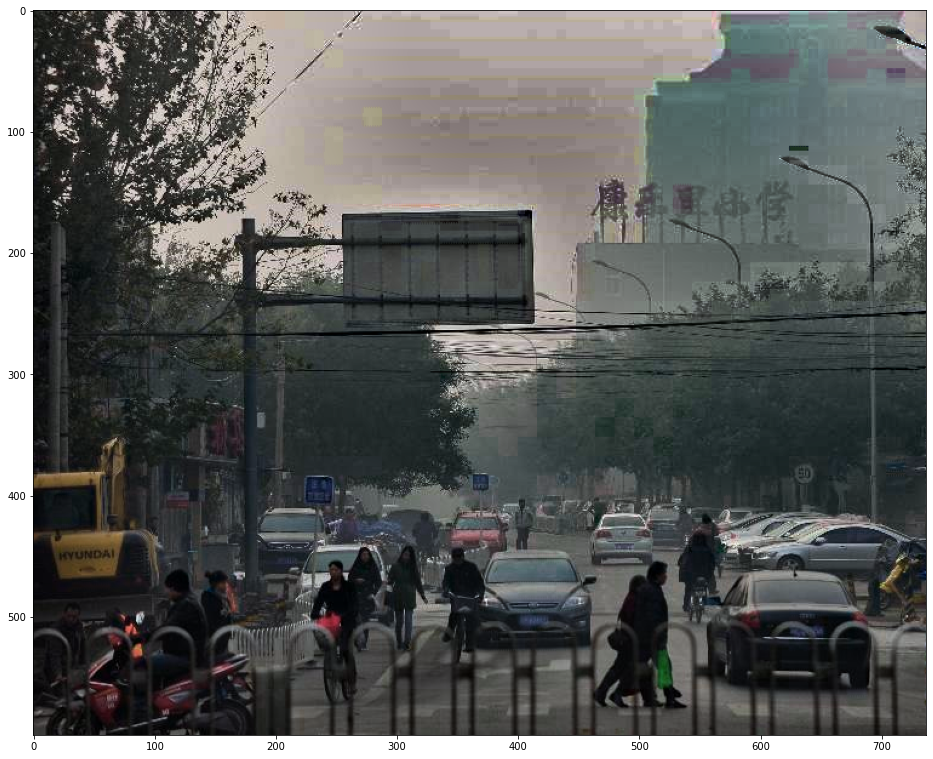

In [15]:
plt.figure(figsize=(16, 16))
plt.imshow(dehazed)